Epoch [100/1000], Loss: 0.0781
Epoch [200/1000], Loss: 0.0685
Epoch [300/1000], Loss: 0.0779
Epoch [400/1000], Loss: 0.0684
Epoch [500/1000], Loss: 0.0764
Epoch [600/1000], Loss: 0.0866
Epoch [700/1000], Loss: 0.0731
Epoch [800/1000], Loss: 0.0680
Epoch [900/1000], Loss: 0.0840
Epoch [1000/1000], Loss: 0.0732
Actual parameters:
[0.5828233169459215, 0.4525214870042456, 0.015251652262328427, 0.9639393939393941, 0.9979869149471565, 0.356618017111223, 0.0938791973379046]
Predicted parameters:
[0.48677003383636475, 1063.31396484375, 0.04777658358216286, 0.49148795008659363, 1053.936279296875, 534.5250244140625, 487.7805480957031]

Actual parameters:
[0.925253336008829, 0.9702806254530392, 0.050432130147432065, 0.4000000000000001, 0.09843985908404629, 0.9554101660795168, 0.23424422708480383]
Predicted parameters:
[0.6574394106864929, 1428.7724609375, 0.0341230146586895, 0.5550711154937744, 812.8944091796875, 595.2460327148438, 352.29791259765625]

Actual parameters:
[0.5551319353867763, 0.52

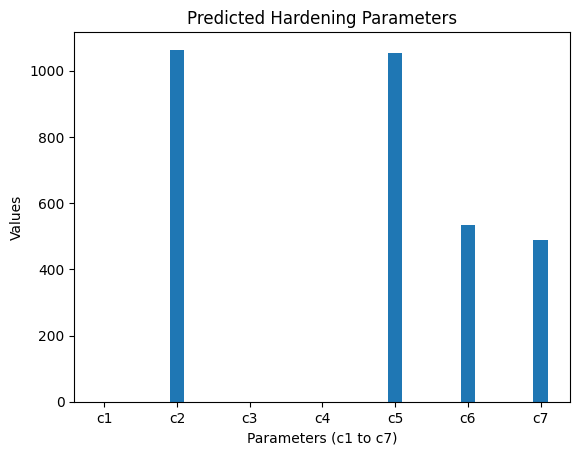

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Load your data
X_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_combined_FD.csv").values
Y_data = pd.read_csv("MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv").values

# Data scaling
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(X_data)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(Y_data)

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X_data_scaled, Y_data_scaled, test_size=0.2, random_state=42)

# DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the updated neural network model
class UpdatedNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, lambda_reg):
        super(UpdatedNeuralNetwork, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_sizes[i]))
            layers.append(nn.Dropout(0.5))
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)
        self.lambda_reg = lambda_reg

    def forward(self, x):
        return self.layers(x)

    def l2_regularization(self):
        l2_reg = 0.0
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                l2_reg += torch.norm(layer.weight)
        return self.lambda_reg * l2_reg

# Custom loss function with regularization
class CustomMSELoss(nn.Module):
    def __init__(self, lambda_reg):
        super(CustomMSELoss, self).__init__()
        self.lambda_reg = lambda_reg

    def forward(self, outputs, targets, model):
        mse_loss = nn.MSELoss()(outputs, targets)
        return mse_loss + model.l2_regularization()

# Hyperparameters
input_size = X_train.shape[1]
hidden_sizes = [128, 128, 64]
output_size = Y_train.shape[1]
lambda_reg = 0.001

# Instantiate the updated model
model = UpdatedNeuralNetwork(input_size, hidden_sizes, output_size, lambda_reg)
criterion = CustomMSELoss(lambda_reg)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets, model)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Optional: Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    val_inputs = torch.tensor(X_val, dtype=torch.float32)
    val_outputs = model(val_inputs)
    val_predictions = target_scaler.inverse_transform(val_outputs.numpy())

# Print and visualize results for a few samples
for i in range(10):
    print(f'Actual parameters:')
    print(Y_val[i * 101].tolist())

    print(f'Predicted parameters:')
    print(val_predictions[i * 101].tolist())
    print()

# Visualize 'c1' to 'c7' values in a single graph for one sample
param_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
param_values = val_predictions[0, :7]

plt.bar(np.arange(len(param_names)), param_values, width=0.2)
plt.xlabel('Parameters (c1 to c7)')
plt.ylabel('Values')
plt.title('Predicted Hardening Parameters')
plt.xticks(np.arange(len(param_names)), param_names)
plt.show()


In [2]:
filtered_indices = np.where((val_predictions[:, 0] >= 2) & (val_predictions[:, 0] <= 3.5))[0]
filtered_predictions = val_predictions[filtered_indices]

for i in range(len(filtered_indices)):
    idx = filtered_indices[i]
    print(f'Actual parameters for filtered sample {i + 1}:')
    print(Y_val[idx * 101].tolist())

    print(f'Predicted parameters for filtered sample {i + 1}:')
    print(filtered_predictions[i].tolist())
    print()

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Define ideal parameters
ideal_params = {
    'c1': 0.5,
    'c2': 1300,
    'c3': 2.3e-14,
    'c4': 0.075,
    'c5': 773.18,
    'c6': 1039.37,
    'c7': 73.94
}

# Load the data
x_data_path = 'MODEL_DATA/NEWDATA/newData_combined_FD.csv'  
y_data_path = 'MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv' 

x_data = pd.read_csv(x_data_path)
y_data = pd.read_csv(y_data_path)

# Use a subset of the data for faster training
subset_percentage = 0.99
x_data_subset, _, y_data_subset, _ = train_test_split(x_data, y_data, test_size=1 - subset_percentage, random_state=42)

# Data scaling
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(x_data_subset)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(y_data_subset)

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X_data_scaled, Y_data_scaled, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = X_train.shape[1]
hidden_sizes = [128, 128, 64]
output_size = Y_train.shape[1]
percentage_range=(88,95)
# Instantiate the model
model = NeuralNetwork(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_val_tensor)
    # Inverse transform to get the predictions in the original scale
    predictions_np = predictions.numpy()
    predicted_parameters = target_scaler.inverse_transform(predictions_np)


Epoch [100/1000], Loss: 0.0682
Epoch [200/1000], Loss: 0.0518
Epoch [300/1000], Loss: 0.0555
Epoch [400/1000], Loss: 0.0551
Epoch [500/1000], Loss: 0.0421
Epoch [600/1000], Loss: 0.0396
Epoch [700/1000], Loss: 0.0396
Epoch [800/1000], Loss: 0.0435
Epoch [900/1000], Loss: 0.0447
Epoch [1000/1000], Loss: 0.0344
c1: Predicted = 5.14e-01, Ideal = 5.00e-01, Close = 92.59%
c2: Predicted = 1.33e+03, Ideal = 1.30e+03, Close = 94.96%
c3: Predicted = 2.34e-14, Ideal = 2.30e-14, Close = 88.40%
c4: Predicted = 7.19e-02, Ideal = 7.50e-02, Close = 91.52%
c5: Predicted = 7.44e+02, Ideal = 7.73e+02, Close = 91.59%
c6: Predicted = 1.02e+03, Ideal = 1.04e+03, Close = 93.06%
c7: Predicted = 7.76e+01, Ideal = 7.39e+01, Close = 92.59%


In [4]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np


# Load the data
x_data_path = 'MODEL_DATA/NEWDATA/newData_combined_FD.csv'  
y_data_path = 'MODEL_DATA/NEWDATA/newData_expanded_realHardParam.csv' 

x_data = pd.read_csv(x_data_path)
y_data = pd.read_csv(y_data_path)

# Use a subset of the data for faster training
subset_percentage = 0.99
x_data_subset, _, y_data_subset, _ = train_test_split(x_data, y_data, test_size=1 - subset_percentage, random_state=42)

# Data scaling
input_scaler = MinMaxScaler()
X_data_scaled = input_scaler.fit_transform(x_data_subset)

target_scaler = MinMaxScaler()
Y_data_scaled = target_scaler.fit_transform(y_data_subset)

# Split the data
X_train, X_val, Y_train, Y_val = train_test_split(X_data_scaled, Y_data_scaled, test_size=0.2, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

# Hyperparameters
input_size = X_train.shape[1]
hidden_sizes = [128, 128, 64]
output_size = Y_train.shape[1]
percentage_range=(88,95)
# Instantiate the model
model = NeuralNetwork(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    predictions = model(X_val_tensor)
    # Inverse transform to get the predictions in the original scale
    predictions_np = predictions.numpy()
    predicted_parameters = target_scaler.inverse_transform(predictions_np)

print(predicted_parameters)

Epoch [100/1000], Loss: 0.0619
Epoch [200/1000], Loss: 0.0592
Epoch [300/1000], Loss: 0.0445
Epoch [400/1000], Loss: 0.0529
Epoch [500/1000], Loss: 0.0491
Epoch [600/1000], Loss: 0.0518
Epoch [700/1000], Loss: 0.0408
Epoch [800/1000], Loss: 0.0397
Epoch [900/1000], Loss: 0.0356
Epoch [1000/1000], Loss: 0.0362
[[6.5960956e-01 1.2167325e+03 4.3059833e-02 ... 1.1499620e+03
  2.6903714e+02 4.8778537e+02]
 [5.4969174e-01 9.6498383e+02 4.8535421e-02 ... 8.5773663e+02
  5.9072540e+02 5.4770435e+02]
 [1.3317360e-01 9.4420502e+02 7.7501602e-02 ... 1.8400776e+03
  9.2035193e+02 2.2355586e+02]
 ...
 [7.1354121e-01 1.1241709e+03 4.9105518e-02 ... 7.6527557e+02
  3.3871411e+02 4.3495676e+02]
 [2.1795306e-01 8.7754144e+02 6.2281080e-03 ... 1.1311980e+03
  8.1119800e+02 9.2545056e+02]
 [5.3359616e-01 1.0375637e+03 3.9980307e-02 ... 9.7916888e+02
  4.2759869e+02 3.6603665e+02]]
